# SAS Viya Workbench를 활용한 Python 기반 데이터 분석

## 0. 사전 작업

### 0.1. 패키지 설치

In [4]:
# a) 데이터 핸들링 및 그래프 관련 패키지 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import joblib

# b) 데이터 전처리 관련 패키지
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import SimpleImputer

# c) 알고리즘 패키지
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sasviya.ml.tree import ForestClassifier as viya_rf, GradientBoostingClassifier as viya_gbm
from sklearn.ensemble import RandomForestClassifier as python_rf, GradientBoostingClassifier as python_gbm

# d) 모델 성능 평가 관련 패키지
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc, roc_auc_score

### 0.2. 그래프 정의

In [5]:
# a) Confusion Matrix 그래프 정의
def plot_confusion_matrix(ax, cm, classes=[0,1], title='Confusion Matrix without normalization', cmap=plt.cm.Blues):
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
# b) Roc(Auc) Curve 그래프 정의
def plot_roc(ax, y_train, y_train_score, title):
    if y_train_score.ndim == 2: 
        fpr, tpr, _ = roc_curve(y_train, y_train_score[:, 1]) 
    else:
        fpr, tpr, _ = roc_curve(y_train, y_train_score)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

## 1. 데이터 가져오기

### 1.1. 데이터 로드

In [6]:
hmeq = pd.read_csv("/workspaces/myfolder/svw-demo/data/demo_hmeq.csv")

### 1.2. 값 확인

In [7]:
hmeq.head(20)

,ID,SEX,RACE,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,M,Black,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,2,F,Black,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,3,F,White,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,4,F,White,1,1500,NaN,NaN,Null,Null,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,M,White,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
5,6,M,Multiracial,1,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614
6,7,M,White,1,1800,48649.0,57037.0,HomeImp,Other,5.0,3.0,2.0,77.100000,1.0,17.0,NaN
7,8,M,White,1,1800,28502.0,43034.0,HomeImp,Other,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894
8,9,F,White,1,2000,32700.0,46740.0,HomeImp,Other,3.0,0.0,2.0,216.933333,1.0,12.0,NaN
9,10,F,Multiracial,1,2000,NaN,62250.0,HomeImp,Sales,16.0,0.0,0.0,115.800000,0.0,13.0,NaN


### 1.3. 컬럼 속성 확인

In [8]:
hmeq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       5960 non-null   int64  
 1   SEX      5960 non-null   object 
 2   RACE     5960 non-null   object 
 3   BAD      5960 non-null   int64  
 4   LOAN     5960 non-null   int64  
 5   MORTDUE  5442 non-null   float64
 6   VALUE    5848 non-null   float64
 7   REASON   5960 non-null   object 
 8   JOB      5960 non-null   object 
 9   YOJ      5445 non-null   float64
 10  DEROG    5252 non-null   float64
 11  DELINQ   5380 non-null   float64
 12  CLAGE    5652 non-null   float64
 13  NINQ     5450 non-null   float64
 14  CLNO     5738 non-null   float64
 15  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(3), object(4)
memory usage: 745.1+ KB


## 2. 데이터 탐색 및 전처리

### 2.1. 데이터 분리

In [9]:
# a) id 변수
hmeq_id = hmeq[['ID', 'SEX', 'RACE']]

# b) 타겟 변수
hmeq_tgt = hmeq['BAD']

# c) 수치형 변수
hmeq_num = hmeq.select_dtypes(include=[np.number]).drop(columns=['ID', 'BAD'])

# d) 범주형 변수
hmeq_cat = hmeq.select_dtypes(include=['object', 'category']).drop(columns=['SEX', 'RACE'])

### 2.2. 수치형 변수

#### 1) 분포

In [10]:
hmeq_num_summary = []

for col in hmeq_num.columns:
    col_data = hmeq_num[col]
    hmeq_num_summary.append({
        "Variable": col,
        "Mean": col_data.mean(),
        "Std Dev": col_data.std(),
        "Min": col_data.min(),
        "Max": col_data.max(),
        "Missing Values": col_data.isnull().sum(),
        "25%": col_data.quantile(0.25),
        "50%": col_data.quantile(0.5),
        "75%": col_data.quantile(0.75)
    })

hmeq_num_summary = pd.DataFrame(hmeq_num_summary)
hmeq_num_summary

,Variable,Mean,Std Dev,Min,Max,Missing Values,25%,50%,75%
0,LOAN,18607.969799,11207.480417,1100.000000,89900.000000,0,11100.000000,16300.000000,23300.000000
1,MORTDUE,73760.817200,44457.609458,2063.000000,399550.000000,518,46276.000000,65019.000000,91488.000000
2,VALUE,101776.048741,57385.775334,8000.000000,855909.000000,112,66075.500000,89235.500000,119824.250000
3,YOJ,8.922268,7.573982,0.000000,41.000000,515,3.000000,7.000000,13.000000
4,DEROG,0.254570,0.846047,0.000000,10.000000,708,0.000000,0.000000,0.000000
5,DELINQ,0.449442,1.127266,0.000000,15.000000,580,0.000000,0.000000,0.000000
6,CLAGE,179.766275,85.810092,0.000000,1168.233561,308,115.116702,173.466667,231.562278
7,NINQ,1.186055,1.728675,0.000000,17.000000,510,0.000000,1.000000,2.000000
8,CLNO,21.296096,10.138933,0.000000,71.000000,222,15.000000,20.000000,26.000000
9,DEBTINC,33.779915,8.601746,0.524499,203.312149,1267,29.140031,34.818262,39.003141


#### 2) 전처리

##### (1) 결측치 처리

In [11]:
 hmeq_num = hmeq_num.fillna(hmeq_num.mean())

##### (2) 구간화 (Binning)

In [12]:
# a) 의사결정 트리 학습
tree = DecisionTreeClassifier(min_samples_leaf=2, max_leaf_nodes=20, random_state=42)
tree.fit(hmeq_num, hmeq_tgt)

# b) 트리 기반 각 변수에 대해 비닝 적용
for column in hmeq_num.columns:
    binning = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
    hmeq_num[column] = binning.fit_transform(hmeq_num[[column]]).flatten() + 1
    hmeq_num_bin = hmeq_num

hmeq_num_bin

/usr/local/lib64/python3.11/site-packages/sklearn/preprocessing/_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib64/python3.11/site-packages/sklearn/preprocessing/_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib64/python3.11/site-packages/sklearn/preprocessing/_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib64/python3.11/site-packages/sklearn/preprocessing/_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,1.0,1.0,8.0,1.0,1.0,2.0,2.0,1.0,5.0
1,1.0,6.0,3.0,5.0,1.0,2.0,3.0,1.0,3.0,5.0
2,1.0,1.0,1.0,4.0,1.0,1.0,4.0,2.0,2.0,5.0
3,1.0,7.0,7.0,7.0,2.0,1.0,6.0,3.0,6.0,5.0
4,1.0,9.0,7.0,3.0,1.0,1.0,2.0,1.0,3.0,5.0
...,...,...,...,...,...,...,...,...,...,...
5955,10.0,4.0,6.0,9.0,1.0,1.0,8.0,1.0,4.0,6.0
5956,10.0,4.0,6.0,9.0,1.0,1.0,7.0,1.0,3.0,6.0
5957,10.0,4.0,6.0,9.0,1.0,1.0,8.0,1.0,3.0,6.0
5958,10.0,3.0,6.0,9.0,1.0,1.0,8.0,1.0,4.0,5.0


### 2.3. 범주형 변수

#### 1) 분포

In [13]:
hmeq_cat_summary = []

for col in hmeq_cat.columns:
    col_data = hmeq_cat[col]
    hmeq_cat_summary.append({
        "Variable": col,
        "Unique Values": col_data.nunique(),
        "Missing Values": col_data.isnull().sum(),
        "Value Counts": col_data.value_counts().to_dict()
    })

hmeq_cat_summary = pd.DataFrame(hmeq_cat_summary)
hmeq_cat_summary

,Variable,Unique Values,Missing Values,Value Counts
0,REASON,3,0,"{'DebtCon': 3928, 'HomeImp': 1780, 'Null': 252}"
1,JOB,7,0,"{'Other': 2388, 'ProfExe': 1276, 'Office': 948..."


#### 2) 전처리

##### (1) 결측치 처리

In [14]:
imputer = SimpleImputer(strategy='constant', fill_value='Null')
hmeq_cat = imputer.fit_transform(hmeq_cat)
hmeq_cat = pd.DataFrame(hmeq_cat, columns=['REASON', 'JOB'])
hmeq_cat

,REASON,JOB
0,HomeImp,Other
1,HomeImp,Other
2,HomeImp,Other
3,Null,Null
4,HomeImp,Office
...,...,...
5955,DebtCon,Other
5956,DebtCon,Other
5957,DebtCon,Other
5958,DebtCon,Other


##### (2) 더미화 (One-hot encoding)

In [15]:
hmeq_cat_dum = pd.get_dummies(data=hmeq_cat, columns=['REASON', 'JOB'], drop_first=False)
hmeq_cat_dum

,REASON_DebtCon,REASON_HomeImp,REASON_Null,JOB_Mgr,JOB_Null,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,False,True,False,False,False,False,True,False,False,False
1,False,True,False,False,False,False,True,False,False,False
2,False,True,False,False,False,False,True,False,False,False
3,False,False,True,False,True,False,False,False,False,False
4,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
5955,True,False,False,False,False,False,True,False,False,False
5956,True,False,False,False,False,False,True,False,False,False
5957,True,False,False,False,False,False,True,False,False,False
5958,True,False,False,False,False,False,True,False,False,False


## 3. 데이터 정리

### 3.1. 데이터 결합

In [16]:
hmeq_full = pd.concat([hmeq_id, hmeq_tgt, hmeq_num_bin, hmeq_cat_dum], axis=1)
hmeq_full

,ID,SEX,RACE,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,...,REASON_DebtCon,REASON_HomeImp,REASON_Null,JOB_Mgr,JOB_Null,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,M,Black,1,1.0,1.0,1.0,8.0,1.0,1.0,...,False,True,False,False,False,False,True,False,False,False
1,2,F,Black,1,1.0,6.0,3.0,5.0,1.0,2.0,...,False,True,False,False,False,False,True,False,False,False
2,3,F,White,1,1.0,1.0,1.0,4.0,1.0,1.0,...,False,True,False,False,False,False,True,False,False,False
3,4,F,White,1,1.0,7.0,7.0,7.0,2.0,1.0,...,False,False,True,False,True,False,False,False,False,False
4,5,M,White,0,1.0,9.0,7.0,3.0,1.0,1.0,...,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,5956,F,White,0,10.0,4.0,6.0,9.0,1.0,1.0,...,True,False,False,False,False,False,True,False,False,False
5956,5957,F,White,0,10.0,4.0,6.0,9.0,1.0,1.0,...,True,False,False,False,False,False,True,False,False,False
5957,5958,F,White,0,10.0,4.0,6.0,9.0,1.0,1.0,...,True,False,False,False,False,False,True,False,False,False
5958,5959,F,White,0,10.0,3.0,6.0,9.0,1.0,1.0,...,True,False,False,False,False,False,True,False,False,False


### 3.2. 데이터 분할

#### 1) 입력변수, 반응변수 분할

In [17]:
hmeq_x = hmeq_full.drop(columns=['ID', 'SEX', 'RACE', 'BAD'])
hmeq_y = hmeq_full['BAD']

#### 2) 학습용, 테스트용 분할

In [18]:
# 데이터 분할 7:3 (학습용 데이터:테스트용데이터)
hmeq_train_x, hmeq_test_x, hmeq_train_y, hmeq_test_y = train_test_split(hmeq_x, hmeq_y, test_size = 0.3, random_state = 10)

print("## Train size:", hmeq_train_x.shape[0])
print("##  Test size:", hmeq_test_x.shape[0] )

## Train size: 4172
##  Test size: 1788


## 4. 모형 학습

### 4.1. Random Forest 모형

#### 1) SAS Viya 모형

In [19]:
vi_rf = viya_rf(
    n_estimators      = 100,
    max_depth         = 10,
    criterion         = 'gini',          
    random_state      = 10         
)

vi_rf.fit(hmeq_train_x, hmeq_train_y)

ForestClassifier(criterion="gini", max_depth=10, random_state=10)

#### 2) Python 모형

In [20]:
py_rf = python_rf(
    n_estimators      = 100,
    max_depth         = 10,
    criterion         = 'gini',          
    random_state      = 10         
)

py_rf.fit(hmeq_train_x, hmeq_train_y)

RandomForestClassifier(max_depth=10, random_state=10)

### 4.2. Gradient Boost Machine 모형

#### 1) SAS Viya 모형

In [21]:
vi_gb = viya_gbm(
    n_estimators      = 100,
    max_depth         = 5,    
    learning_rate     = 0.1,
    random_state      = 10           
)

vi_gb.fit(hmeq_train_x, hmeq_train_y)

GradientBoostingClassifier(max_depth=5, random_state=10)

#### 2) Python 모형

In [22]:
py_gb = python_gbm(
    n_estimators      = 100,
    max_depth         = 5,    
    learning_rate     = 0.1,
    random_state      = 10           
)

py_gb.fit(hmeq_train_x, hmeq_train_y)

GradientBoostingClassifier(max_depth=5, random_state=10)

## 4. 모형 평가

### 4.1. 모형 성능 평가

#### 1) 모형 성능 지표 산출

##### (1) 학습용 데이터

In [23]:
# a) SAS Viya - Random Forest
hmeq_train_vi_rf_pred = vi_rf.predict(hmeq_train_x)
vi_rf_train_accuracy = round(accuracy_score(hmeq_train_y, hmeq_train_vi_rf_pred), 3)
vi_rf_train_recall = round(recall_score(hmeq_train_y, hmeq_train_vi_rf_pred, average='macro'), 3)
vi_rf_train_precision = round(precision_score(hmeq_train_y, hmeq_train_vi_rf_pred, average='macro'), 3)

# b) Python - Random Forest
hmeq_train_py_rf_pred = py_rf.predict(hmeq_train_x)
py_rf_train_accuracy = round(accuracy_score(hmeq_train_y, hmeq_train_py_rf_pred), 3)
py_rf_train_recall = round(recall_score(hmeq_train_y, hmeq_train_py_rf_pred, average='macro'), 3)
py_rf_train_precision = round(precision_score(hmeq_train_y, hmeq_train_py_rf_pred, average='macro'), 3)

# c) SAS Viya - Gradient Boost Machine
hmeq_train_vi_gb_pred = vi_gb.predict(hmeq_train_x)
vi_gb_train_accuracy = round(accuracy_score(hmeq_train_y, hmeq_train_vi_gb_pred), 3)
vi_gb_train_recall = round(recall_score(hmeq_train_y, hmeq_train_vi_gb_pred, average='macro'), 3)
vi_gb_train_precision = round(precision_score(hmeq_train_y, hmeq_train_vi_gb_pred, average='macro'), 3)

# d) SAS Python - Gradient Boost Machine
hmeq_train_py_gb_pred = py_gb.predict(hmeq_train_x)
py_gb_train_accuracy = round(accuracy_score(hmeq_train_y, hmeq_train_py_gb_pred), 3)
py_gb_train_recall = round(recall_score(hmeq_train_y, hmeq_train_py_gb_pred, average='macro'), 3)
py_gb_train_precision = round(precision_score(hmeq_train_y, hmeq_train_py_gb_pred, average='macro'), 3)

##### (2) 테스트용 데이터

In [24]:
# a) SAS Viya - Random Forest
hmeq_test_vi_rf_pred = vi_rf.predict(hmeq_test_x)
vi_rf_test_accuracy = round(accuracy_score(hmeq_test_y, hmeq_test_vi_rf_pred), 3)
vi_rf_test_recall = round(recall_score(hmeq_test_y, hmeq_test_vi_rf_pred, average='macro'), 3)
vi_rf_test_precision = round(precision_score(hmeq_test_y, hmeq_test_vi_rf_pred, average='macro'), 3)

# b) Python - Random Forest
hmeq_test_py_rf_pred = py_rf.predict(hmeq_test_x)
py_rf_test_accuracy = round(accuracy_score(hmeq_test_y, hmeq_test_py_rf_pred), 3)
py_rf_test_recall = round(recall_score(hmeq_test_y, hmeq_test_py_rf_pred, average='macro'), 3)
py_rf_test_precision = round(precision_score(hmeq_test_y, hmeq_test_py_rf_pred, average='macro'), 3)

# c) SAS Viya - Gradient Boost Machine
hmeq_test_vi_gb_pred = vi_gb.predict(hmeq_test_x)
vi_gb_test_accuracy = round(accuracy_score(hmeq_test_y, hmeq_test_vi_gb_pred), 3)
vi_gb_test_recall = round(recall_score(hmeq_test_y, hmeq_test_vi_gb_pred, average='macro'), 3)
vi_gb_test_precision = round(precision_score(hmeq_test_y, hmeq_test_vi_gb_pred, average='macro'), 3)

# d) SAS Python - Gradient Boost Machine
hmeq_test_py_gb_pred = py_gb.predict(hmeq_test_x)
py_gb_test_accuracy = round(accuracy_score(hmeq_test_y, hmeq_test_py_gb_pred), 3)
py_gb_test_recall = round(recall_score(hmeq_test_y, hmeq_test_py_gb_pred, average='macro'), 3)
py_gb_test_precision = round(precision_score(hmeq_test_y, hmeq_test_py_gb_pred, average='macro'), 3)

##### (3) 테이블 결합

In [30]:
model_results = []
model_results.append(["SAS Viya", "Random Forest", vi_rf_train_accuracy, vi_rf_train_recall, vi_rf_train_precision, vi_rf_test_accuracy, vi_rf_test_recall, vi_rf_test_precision])
model_results.append(["Python", "Random Forest", py_rf_train_accuracy, py_rf_train_recall, py_rf_train_precision, py_rf_test_accuracy, py_rf_test_recall, py_rf_test_precision])
model_results.append(["SAS Viya", "Gradient Boosting Machine", vi_gb_train_accuracy, vi_gb_train_recall, vi_gb_train_precision, vi_gb_test_accuracy, vi_gb_test_recall, vi_gb_test_precision])
model_results.append(["Python", "Gradient Boosting Machine", py_gb_train_accuracy, py_gb_train_recall, py_gb_train_precision, py_gb_test_accuracy, py_gb_test_recall, py_gb_test_precision])
model_results = pd.DataFrame(model_results, columns=["Language", "Model", "Train_Accuracy", "Train_Recall", "Train_Precision", "Test_Accuracy", "Test_Recall", "Test_Precision"])
model_results


,Language,Model,Train_Accuracy,Train_Recall,Train_Precision,Test_Accuracy,Test_Recall,Test_Precision
0,SAS Viya,Random Forest,0.905,0.792,0.901,0.888,0.747,0.867
1,Python,Random Forest,0.941,0.858,0.961,0.892,0.750,0.884
2,SAS Viya,Gradient Boosting Machine,0.947,0.893,0.940,0.909,0.812,0.881
3,Python,Gradient Boosting Machine,0.961,0.916,0.961,0.909,0.812,0.882


#### 3) Confusion Matrix, ROC Curve 그리기

##### (1) SAS Viya - Random Forest 모형

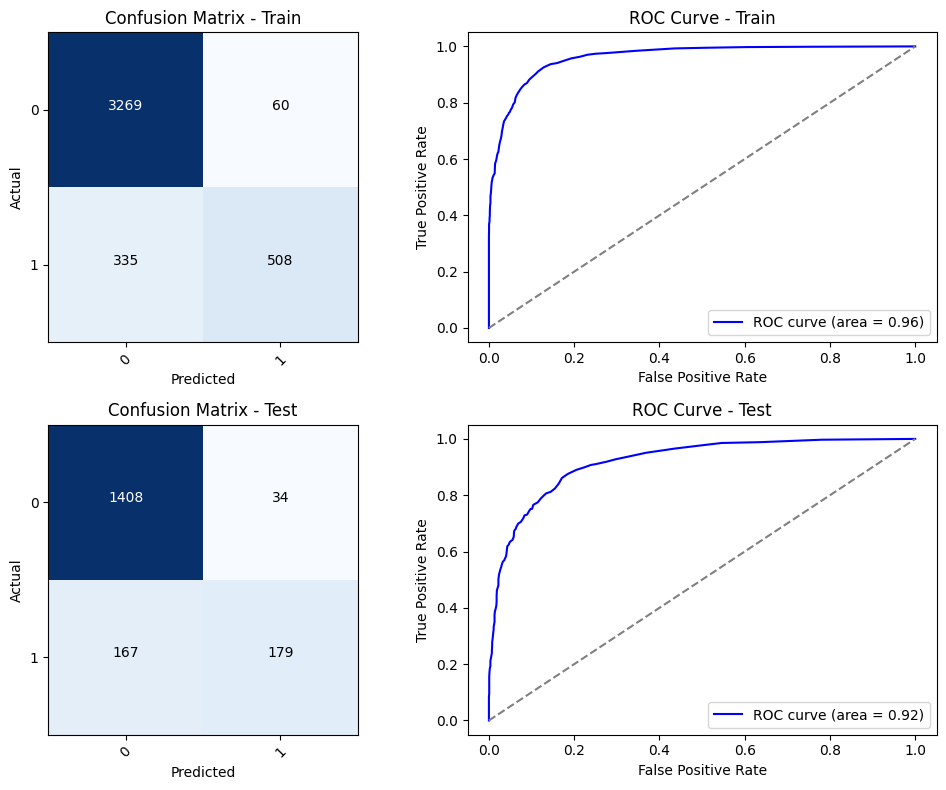

In [26]:
# (1) 학습용 데이터 스코어링
hmeq_train_vi_rf_pred = vi_rf.predict(hmeq_train_x)
hmeq_train_vi_rf_cm = confusion_matrix(hmeq_train_y, hmeq_train_vi_rf_pred)
hmeq_train_vi_rf_score= np.array(vi_rf.predict_proba(hmeq_train_x))

# b) 테스트용 데이터 스코어링
hmeq_test_vi_rf_pred = vi_rf.predict(hmeq_test_x)
hmeq_test_vi_rf_cm = confusion_matrix(hmeq_test_y, hmeq_test_vi_rf_pred)
hmeq_test_vi_rf_score= np.array(vi_rf.predict_proba(hmeq_test_x))

# c) 그래프 모양 설정
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# d) Confusion Matrix 그래프 생성
plot_confusion_matrix(axs[0,0], hmeq_train_vi_rf_cm, classes=np.unique(hmeq_train_y), title='Confusion Matrix - Train')
plot_confusion_matrix(axs[1,0], hmeq_test_vi_rf_cm, classes=np.unique(hmeq_train_y), title='Confusion Matrix - Test')

# e) ROC(AUC) Curve 그래프 생성
plot_roc(axs[0,1], hmeq_train_y, hmeq_train_vi_rf_score, title='ROC Curve - Train')
plot_roc(axs[1,1], hmeq_test_y, hmeq_test_vi_rf_score, title='ROC Curve - Test')

plt.tight_layout() 
plt.show()


##### (2) Python - Random Forest 모형

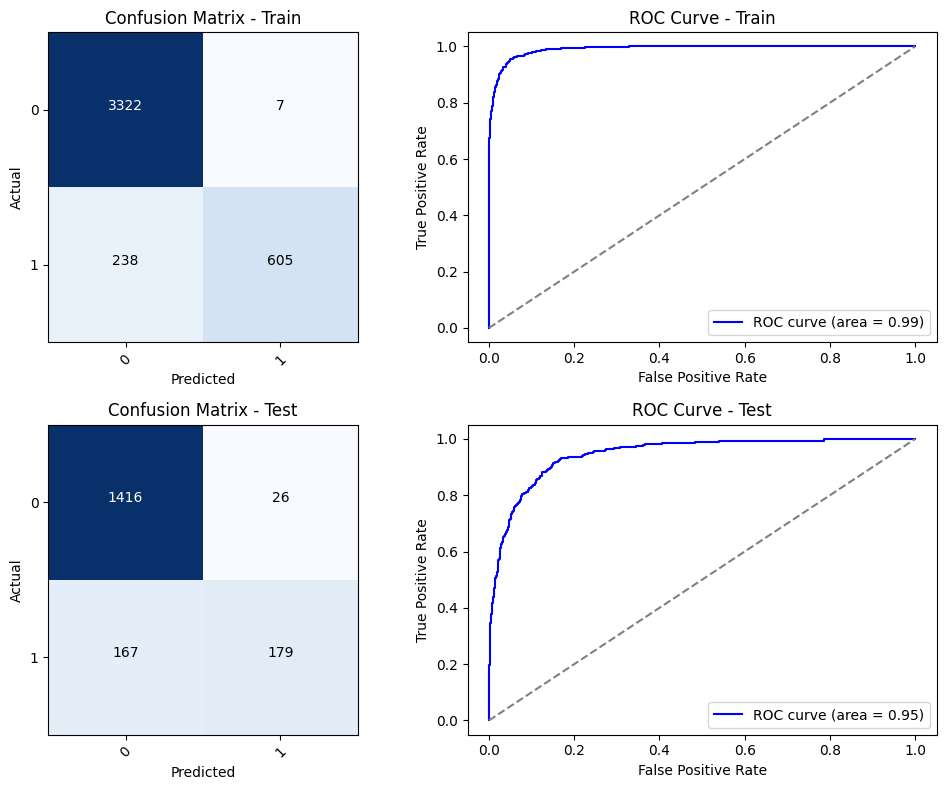

In [27]:
# a) 학습용 데이터 스코어링
hmeq_train_py_rf_pred = py_rf.predict(hmeq_train_x)
hmeq_train_py_rf_cm = confusion_matrix(hmeq_train_y, hmeq_train_py_rf_pred)
hmeq_train_py_rf_score= py_rf.predict_proba(hmeq_train_x)

# b) 테스트용 데이터 스코어링
hmeq_test_py_rf_pred = py_rf.predict(hmeq_test_x)
hmeq_test_py_rf_cm = confusion_matrix(hmeq_test_y, hmeq_test_py_rf_pred)
hmeq_test_py_rf_score= py_rf.predict_proba(hmeq_test_x)

# c) 그래프 모양 설정
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# d) Confusion Matrix 그래프 생성
plot_confusion_matrix(axs[0,0], hmeq_train_py_rf_cm, classes=np.unique(hmeq_train_y), title='Confusion Matrix - Train')
plot_confusion_matrix(axs[1,0], hmeq_test_py_rf_cm, classes=np.unique(hmeq_train_y), title='Confusion Matrix - Test')

# e) ROC(AUC) Curve 그래프 생성
plot_roc(axs[0,1], hmeq_train_y, hmeq_train_py_rf_score, title='ROC Curve - Train')
plot_roc(axs[1,1], hmeq_test_y, hmeq_test_py_rf_score, title='ROC Curve - Test')

plt.tight_layout() 
plt.show()


##### (3) SAS Viya - Gradient Boost Machine 모형

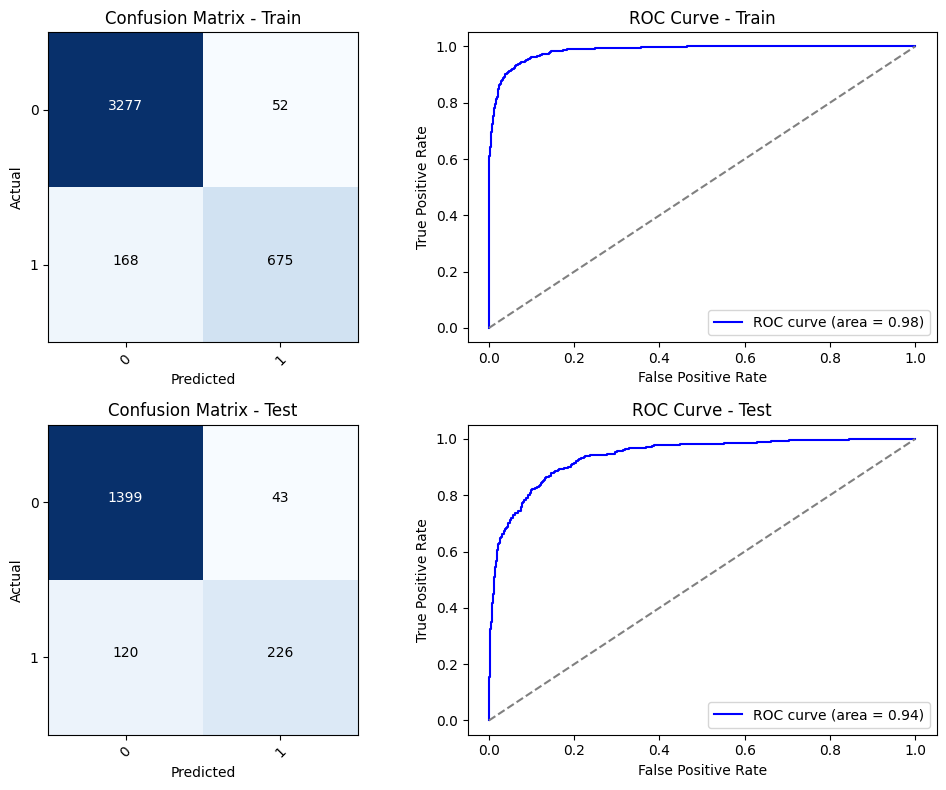

In [28]:
# (1) 학습용 데이터 스코어링
hmeq_train_vi_gb_pred = vi_gb.predict(hmeq_train_x)
hmeq_train_vi_gb_cm = confusion_matrix(hmeq_train_y, hmeq_train_vi_gb_pred)
hmeq_train_vi_gb_score= np.array(vi_gb.predict_proba(hmeq_train_x))

# b) 테스트용 데이터 스코어링
hmeq_test_vi_gb_pred = vi_gb.predict(hmeq_test_x)
hmeq_test_vi_gb_cm = confusion_matrix(hmeq_test_y, hmeq_test_vi_gb_pred)
hmeq_test_vi_gb_score= np.array(vi_gb.predict_proba(hmeq_test_x))

# c) 그래프 모양 설정
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# d) Confusion Matrix 그래프 생성
plot_confusion_matrix(axs[0,0], hmeq_train_vi_gb_cm, classes=np.unique(hmeq_train_y), title='Confusion Matrix - Train')
plot_confusion_matrix(axs[1,0], hmeq_test_vi_gb_cm, classes=np.unique(hmeq_train_y), title='Confusion Matrix - Test')

# e) ROC(AUC) Curve 그래프 생성
plot_roc(axs[0,1], hmeq_train_y, hmeq_train_vi_gb_score, title='ROC Curve - Train')
plot_roc(axs[1,1], hmeq_test_y, hmeq_test_vi_gb_score, title='ROC Curve - Test')

plt.tight_layout() 
plt.show()


##### (4) Python - Gradient Boost Machine 모형

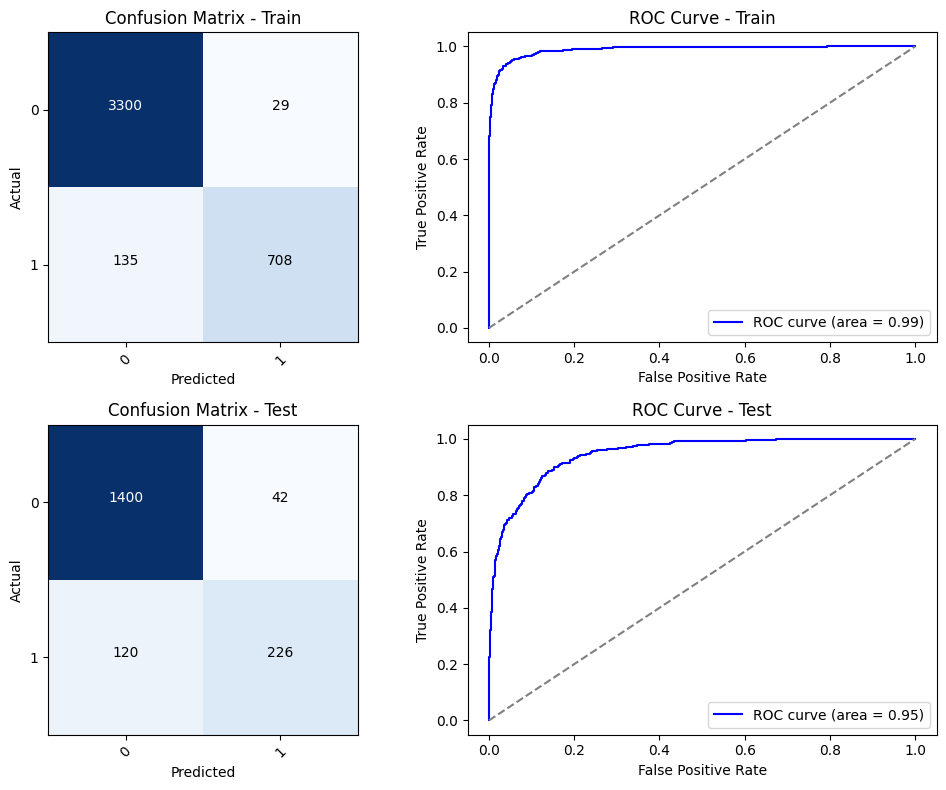

In [29]:
# (1) 학습용 데이터 스코어링
hmeq_train_py_gb_pred = py_gb.predict(hmeq_train_x)
hmeq_train_py_gb_cm = confusion_matrix(hmeq_train_y, hmeq_train_py_gb_pred)
hmeq_train_py_gb_score= py_gb.predict_proba(hmeq_train_x)

# b) 테스트용 데이터 스코어링
hmeq_test_py_gb_pred = py_gb.predict(hmeq_test_x)
hmeq_test_py_gb_cm = confusion_matrix(hmeq_test_y, hmeq_test_py_gb_pred)
hmeq_test_py_gb_score= py_gb.predict_proba(hmeq_test_x)

# c) 그래프 모양 설정
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# d) Confusion Matrix 그래프 생성
plot_confusion_matrix(axs[0,0], hmeq_train_py_gb_cm, classes=np.unique(hmeq_train_y), title='Confusion Matrix - Train')
plot_confusion_matrix(axs[1,0], hmeq_test_py_gb_cm, classes=np.unique(hmeq_train_y), title='Confusion Matrix - Test')

# e) ROC(AUC) Curve 그래프 생성
plot_roc(axs[0,1], hmeq_train_y, hmeq_train_py_gb_score, title='ROC Curve - Train')
plot_roc(axs[1,1], hmeq_test_y, hmeq_test_py_gb_score, title='ROC Curve - Test')

plt.tight_layout() 
plt.show()
